In [1]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
from PIL import Image
import glob 


In [3]:
import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
secure_worker = sy.VirtualWorker(hook, id="secure_worker")


In [4]:
import pandas as pd

df = pd.read_excel ('./multilabels/LandUse_Multilabeled.xlsx')
df_label = np.array(df)



c:\users\karam\anaconda3\envs\pysyft2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
class_names =  np.array(["airplane","bare-soil","buildings","cars","chaparral","court","dock","field","grass","mobile-home","pavement","sand","sea","ship","tanks","trees","water"])


In [6]:
largestxor = 0 
largestij = (0,0)

for i in range(1,17):
    for j in range(i+1,18):
        #colnand = np.sum(np.logical_not(np.logical_and(df_label[:,i], df_label[:,j])))
        colxor = np.sum(np.logical_xor(df_label[:,i].astype(bool) , df_label[:,j].astype(bool) )) -  np.sum(np.logical_and(df_label[:,i], df_label[:,j]))
        #print(i,j, colxor, colnand)
        if colxor >= largestxor and np.sum(df_label[:,i]) >=700 and np.sum(df_label[:,j])>= 700 :
            largestxor = colxor
            largestij = (i,j)
print(largestxor,class_names[largestij[0]-1], class_names[largestij[1]-1], largestij)

674 bare-soil cars (2, 4)


In [6]:
print(np.sum(df_label[:,2]),np.sum(df_label[:,4]),  np.sum(np.logical_and(df_label[:,2], df_label[:,4])))

718 886 310


In [7]:
from torch.utils.data import Dataset
from natsort import natsorted

class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform, labelmat):
        self.main_dir = main_dir
        self.transforms = transform
        self.all_imgs = glob.glob(os.path.join(main_dir, '**/*.tif'), recursive=True)
        self.total_imgs = natsorted(self.all_imgs)
        self.xlabels = labelmat
        
    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        #print(idx,len(self.total_imgs))
        img_loc = self.total_imgs[idx]
        #print(img_loc)
        imagebaselabel = os.path.splitext(os.path.basename(img_loc))[0]
        label = self.xlabels[np.where(self.xlabels[:,0] == imagebaselabel),1:].reshape(17).astype(np.int64)
        #print(label,label.shape)
        tensor_label =  torch.from_numpy(label)
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transforms(image)
        return tensor_image, tensor_label

In [8]:
def sampler_split_for_client(cdata, idxs, kp_cls= 4, ig_cls=2):
    print(type(idxs))
    kplist1 = []
    kplist2 = []
    for i in idxs:
        _, label = cdata.__getitem__(i) 
        if label[kp_cls] == 1 and not label[ig_cls]: 
            kplist1.append(i)
        
        elif label[ig_cls] and not label[kp_cls]:
            kplist2.append(i)
        else:
            flip = np.random.randint(2) 
            if flip == 1:
                kplist1.append(i)
                
            else:
                kplist2.append(i)
    print(len(kplist1), len(kplist2))
    return kplist1, kplist2

data_dir = './UCMerced_LandUse/images'
def load_split_train_test(datadir, labelmat,valid_size = .2):
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    train_data = CustomDataSet(datadir, transform=train_transforms, labelmat=labelmat)
    test_data = CustomDataSet(datadir, transform=train_transforms, labelmat=labelmat)

    indices = list(range(2100))
    split = int(np.floor(valid_size * 2100))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler1, train_sampler2 = sampler_split_for_client(train_data, train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader1 = torch.utils.data.DataLoader(train_data,
                   sampler=SubsetRandomSampler(train_sampler1), batch_size=4)
    trainloader2 = torch.utils.data.DataLoader(train_data,
                   sampler=SubsetRandomSampler(train_sampler2), batch_size=4)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=4) 
    return {'bob': trainloader1,'alice':trainloader2,'val': testloader}, {'train': len(train_idx), 'val':len(test_idx)}
dataloaders ,dataset_sizes = load_split_train_test(data_dir, df_label,.2)
print(dataset_sizes)
#class_names = dataloaders['train'].dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<class 'list'>
556 1124
{'train': 1680, 'val': 420}


In [10]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))



criterion = nn.BCEWithLogitsLoss()

In [19]:
iterations = 10
worker_iters = 5

for a_iter in range(iterations):
    print('Epoch {}/{}'.format(a_iter, iterations - 1))
    bobs_model = model_ft.copy().send(bob)
    alices_model = model_ft.copy().send(alice)

    bobs_opt = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    alices_opt = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    running_loss = 0.0
    bobdatalen = 0 
    for inputs, labels in dataloaders['bob']:
        bobdatalen += 1 
        in_size = inputs.size(0)
        bobs_data = inputs.send(bob)
        bobs_target  = labels.send(bob)
        # Train Bob's Model
        bobs_opt.zero_grad()
        bobs_pred = bobs_model(bobs_data)
        bobs_loss = criterion(bobs_pred, bobs_target.type(torch.float))
        bobs_loss.backward()

        bobs_opt.step()
        bobs_loss = bobs_loss.get().data
        running_loss += bobs_loss.item() * in_size
    print("Bob loss:", running_loss/ bobdatalen)

    running_loss = 0.0
    alicedatalen = 0 
    for inputs, labels in dataloaders['alice']:
        alicedatalen += 1 
        in_size = inputs.size(0)
        alices_data = inputs.send(alice)
        alices_target  = labels.send(alice)
        alices_opt.zero_grad()
        alices_pred = alices_model(alices_data)
        alices_loss = criterion(alices_pred, alices_target.type(torch.float))
        alices_loss.backward()

        alices_opt.step()
        alices_loss = alices_loss.get().data
        running_loss += (alices_loss.item() * in_size)
    print("alice loss:", running_loss/ alicedatalen)
    
    alices_model.move(secure_worker)
    bobs_model.move(secure_worker)
    with torch.no_grad():
        for param, aparam, bparam in zip(model_ft.parameters(), alices_model.parameters(), bobs_model.parameters()):
            param = (aparam + bparam)/2
        #model_ft.weight.set_(((alices_model.weight.data + bobs_model.weight.data) / 2).get())
        #model_ft.bias.set_(((alices_model.bias.data + bobs_model.bias.data) / 2).get())
    
    print("Bob:" + str(bobs_loss) + " Alice:" + str(alices_loss))

Epoch 0/9
Bob loss: 2.9200061804019146
alice loss: 2.927842936460576
Bob:tensor(0.7318) Alice:tensor(0.7552)
Epoch 1/9
Bob loss: 2.9143447342866695
alice loss: 2.92631924014294
Bob:tensor(0.7601) Alice:tensor(0.7249)
Epoch 2/9
Bob loss: 2.9216492116821478
alice loss: 2.921022213563956
Bob:tensor(0.7294) Alice:tensor(0.7411)
Epoch 3/9
Bob loss: 2.921941918615969
alice loss: 2.925550454371684
Bob:tensor(0.7644) Alice:tensor(0.7062)
Epoch 4/9
Bob loss: 2.919008306835009
alice loss: 2.9285087539422467
Bob:tensor(0.7088) Alice:tensor(0.7195)
Epoch 5/9
Bob loss: 2.920885367423111
alice loss: 2.9272035134805217
Bob:tensor(0.7721) Alice:tensor(0.7836)
Epoch 6/9
Bob loss: 2.9288351387711047
alice loss: 2.9274453684169814
Bob:tensor(0.7114) Alice:tensor(0.7431)
Epoch 7/9
Bob loss: 2.914701814236848
alice loss: 2.9302189184431864
Bob:tensor(0.7542) Alice:tensor(0.7497)
Epoch 8/9
Bob loss: 2.923298498118146
alice loss: 2.9255809443337575
Bob:tensor(0.7872) Alice:tensor(0.7383)
Epoch 9/9
Bob loss: 

In [22]:
torch.save(model_ft, 'fl_ml_resnet_model.pt')

In [2]:
model = torch.load('fl_ml_resnet_model.pt')

In [9]:
import matplotlib.pyplot as plt

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig, axs = plt.subplots(nrows=num_images, ncols=1, figsize=(8,30))
    rowindx = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = np.heaviside(outputs.cpu().detach().numpy(),0)
            #_, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                #ax = plt.subplot(num_images//2, 2, images_so_far)
                #axs[rowindx, images_so_far%4].axis('off')
                #ax.set_title(f'it is {class_names[labels[j]]} and resnet predicted: {class_names[preds[j]]}')
                axs[rowindx].set_title(f'True label {class_names[labels[j].cpu().numpy() > 0].tolist()}\n Predicted:{class_names[preds[j] > 0].tolist()}', fontsize=12)
                #axs[rowindx].set_title(f'Predicted:{class_names[preds[j] > 0].tolist()}', fontsize=12)
                #imshow(inputs.cpu().data[j])
                
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                axs[rowindx].imshow(inp)
                
                axs[rowindx].set_yticks([])
                axs[rowindx].set_xticks([])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                rowindx +=1
        model.train(mode=was_training)

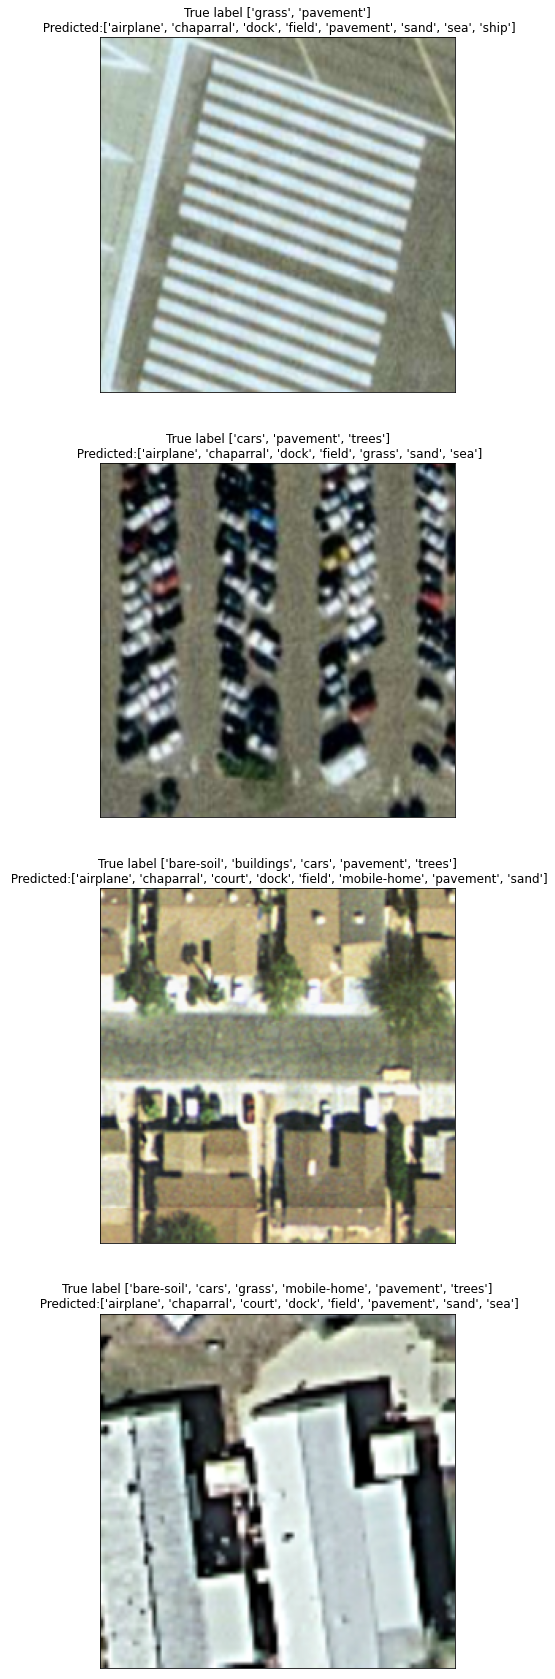

In [11]:
model.to(device)
visualize_model(model, 4)